# Transfer Learning With YAMNet for Heart Sound Classification

[YAMNet](https://tfhub.dev/google/yamnet/1) is a pre-trained deep neural network that can predict audio events from [521 classes](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv), such as laughter, barking, or a siren.

 In this tutorial you will learn how to:

- Load and use the YAMNet model for inference.
- Build a new model using the YAMNet embeddings to classify heart sounds.
- Evaluate and export your model.


## Import TensorFlow and other libraries


Start by installing [TensorFlow I/O](https://www.tensorflow.org/io), which will make it easier for you to load audio files off disk.

In [ ]:
# Use compatible versions of tensorflow and tensorflow_io
!pip install tensorflow==2.15.0 tensorflow-io==0.36.0

In [ ]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

## About YAMNet

[YAMNet](https://github.com/tensorflow/models/tree/master/research/audioset/yamnet) is a pre-trained neural network that employs the [MobileNetV1](https://arxiv.org/abs/1704.04861) depthwise-separable convolution architecture. It can use an audio waveform as input and make independent predictions for each of the 521 audio events from the [AudioSet](http://g.co/audioset) corpus.

Internally, the model extracts "frames" from the audio signal and processes batches of these frames. This version of the model uses frames that are 0.96 second long and extracts one frame every 0.48 seconds .

The model accepts a 1-D float32 Tensor or NumPy array containing a waveform of arbitrary length, represented as single-channel (mono) 16 kHz samples in the range `[-1.0, +1.0]`. This tutorial contains code to help you convert WAV files into the supported format.

The model returns 3 outputs, including the class scores, embeddings (which you will use for transfer learning), and the log mel [spectrogram](https://www.tensorflow.org/tutorials/audio/simple_audio#spectrogram). You can find more details [here](https://tfhub.dev/google/yamnet/1).

One specific use of YAMNet is as a high-level feature extractor - the 1,024-dimensional embedding output. You will use the base (YAMNet) model's input features and feed them into your shallower model consisting of one hidden `tf.keras.layers.Dense` layer. Then, you will train the network on a small amount of data for audio classification _without_ requiring a lot of labeled data and training end-to-end. (This is similar to [transfer learning for image classification with TensorFlow Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) for more information.)

First, you will test the model and see the results of classifying audio. You will then construct the data pre-processing pipeline.

### Loading YAMNet from TensorFlow Hub

You are going to use a pre-trained YAMNet from [Tensorflow Hub](https://tfhub.dev/) to extract the embeddings from the sound files.

Loading a model from TensorFlow Hub is straightforward: choose the model, copy its URL, and use the `load` function.

Note: to read the documentation of the model, use the model URL in your browser.

In [ ]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [ ]:
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/ShebinJoseJacob/test/raw/main/Data.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

27515302/27515302 [==============================] - 0s 0us/step


With the model loaded, you can follow the [YAMNet basic usage tutorial](https://www.tensorflow.org/hub/tutorials/yamnet) and download a sample WAV file to run the inference.


In [ ]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

215546/215546 [==============================] - 0s 0us/step
./test_data/miaow_16k.wav


You will need a function to load audio files, which will also be used later when working with the training data. (Learn more about reading audio files and their labels in [Simple audio recognition](https://www.tensorflow.org/tutorials/audio/simple_audio#reading_audio_files_and_their_labels).

Note: The returned `wav_data` from `load_wav_16k_mono` is already normalized to values in the `[-1.0, 1.0]` range (for more information, go to [YAMNet's documentation on TF Hub](https://tfhub.dev/google/yamnet/1)).

In [ ]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

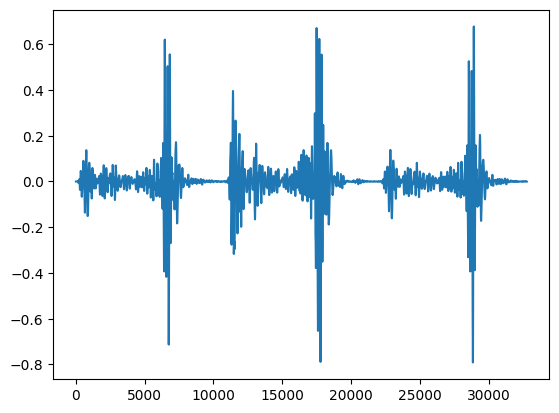

In [ ]:
testing_wav_data = load_wav_16k_mono('./datasets/Data/audio/New_MS_074.wav')

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the class mapping

It's important to load the class names that YAMNet is able to recognize. The mapping file is present at `yamnet_model.class_map_path()` in the CSV format.

In [ ]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


### Run inference

YAMNet provides frame-level class-scores (i.e., 521 scores for every frame). In order to determine clip-level predictions, the scores can be aggregated per-class across frames (e.g., using mean or max aggregation). This is done below by `scores_np.mean(axis=0)`. Finally, to find the top-scored class at the clip-level, you take the maximum of the 521 aggregated scores.


In [ ]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Heart sounds, heartbeat
The embeddings shape: (4, 1024)


Note: The model correctly inferred an animal sound. Your goal in this tutorial is to increase the model's accuracy for specific classes. Also, notice that the model generated 13 embeddings, 1 per frame.

## Heart Sound dataset

The [dataset](https://github.com/Nekhil-haxh/Sign-Language-Translator) is a labeled collection of 1,000 five-second long environmental audio recordings. The dataset consists of 5 classes, with 200 examples per class.

Download the dataset and extract it.


In [ ]:
'''_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/ShebinJoseJacob/test/raw/main/Data.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)'''

"_ = tf.keras.utils.get_file('esc-50.zip',\n                        'https://github.com/ShebinJoseJacob/test/raw/main/Data.zip',\n                        cache_dir='./',\n                        cache_subdir='datasets',\n                        extract=True)"

### Explore the data

The metadata for each file is specified in the csv file at `./datasets/Data/meta/esc50.csv`

and all the audio files are in `./datasets/Data/audio/`

You will create a pandas `DataFrame` with the mapping and use that to have a clearer view of the data.


In [ ]:
esc50_csv = './datasets/Data/meta/metadata.csv'
base_data_path = './datasets/Data/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,file name,fold,target,foldername
0,New_MS_074.wav,5,2,MS
1,New_MS_122.wav,5,2,MS
2,New_MS_024.wav,5,2,MS
3,New_MS_002.wav,5,2,MS
4,New_MS_114.wav,5,2,MS


### Filter the data

Now that the data is stored in the `DataFrame`, apply some transformations:

- Filter out rows and use only the selected classes
- Amend the filename to have the full path. This will make loading easier later.
- Change targets to be within a specific range.

In [ ]:
my_classes = ['AS', 'MR', 'MS', 'MVP', 'N']
map_class_to_id = {'AS':0, 'MR':1, 'MS':2, 'MVP':3, 'N': 4}

filtered_pd = pd_data[pd_data.foldername.isin(my_classes)]

class_id = filtered_pd['foldername'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['file name'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(1000)

,file name,fold,target,foldername,filename
0,New_MS_074.wav,5,2,MS,./datasets/Data/audio/New_MS_074.wav
1,New_MS_122.wav,5,2,MS,./datasets/Data/audio/New_MS_122.wav
2,New_MS_024.wav,5,2,MS,./datasets/Data/audio/New_MS_024.wav
3,New_MS_002.wav,5,2,MS,./datasets/Data/audio/New_MS_002.wav
4,New_MS_114.wav,5,2,MS,./datasets/Data/audio/New_MS_114.wav
...,...,...,...,...,...
995,New_AS_196.wav,1,0,AS,./datasets/Data/audio/New_AS_196.wav
996,New_AS_152.wav,1,0,AS,./datasets/Data/audio/New_AS_152.wav
997,New_AS_106.wav,1,0,AS,./datasets/Data/audio/New_AS_106.wav
998,New_AS_161.wav,1,0,AS,./datasets/Data/audio/New_AS_161.wav


### Load the audio files and retrieve embeddings

Here you'll apply the `load_wav_16k_mono` and prepare the WAV data for the model.

When extracting embeddings from the WAV data, you get an array of shape `(N, 1024)`  where `N` is the number of frames that YAMNet found (one for every 0.48 seconds of audio).

Your model will use each frame as one input. Therefore, you need to create a new column that has one frame per row. You also need to expand the labels and the `fold` column to proper reflect these new rows.

The expanded `fold` column keeps the original values. You cannot mix frames because, when performing the splits, you might end up having parts of the same audio on different splits, which would make your validation and test steps less effective.

In [ ]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec
print(main_ds.take(1000))

<_TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

### Split the data

You will use the `fold` column to split the dataset into train, validation and test sets.

The last step is to remove the `fold` column from the dataset since you're not going to use it during training.


In [ ]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(100).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

## Create your model

You did most of the work!
Next, define a very simple [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model with one hidden layer and two outputs to recognize cats and dogs from sounds.


In [ ]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 527365 (2.01 MB)
Trainable params: 527365 (2.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [ ]:
history = my_model.fit(train_ds,
                       epochs=200,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/200
93/93 [==============================] - 28s 248ms/step - loss: 2.2107 - accuracy: 0.5190 - val_loss: 5.4403 - val_accuracy: 0.2281
Epoch 2/200
93/93 [==============================] - 1s 6ms/step - loss: 2.2184 - accuracy: 0.2866 - val_loss: 1.9723 - val_accuracy: 0.3907
Epoch 3/200
93/93 [==============================] - 1s 6ms/step - loss: 1.6615 - accuracy: 0.3717 - val_loss: 2.0963 - val_accuracy: 0.3784
Epoch 4/200
93/93 [==============================] - 1s 6ms/step - loss: 1.5154 - accuracy: 0.4208 - val_loss: 2.2016 - val_accuracy: 0.4194
Epoch 5/200
93/93 [==============================] - 1s 6ms/step - loss: 1.5101 - accuracy: 0.4181 - val_loss: 1.4728 - val_accuracy: 0.5492
Epoch 6/200
93/93 [==============================] - 1s 6ms/step - loss: 1.3470 - accuracy: 0.4864 - val_loss: 1.1535 - val_accuracy: 0.5984
Epoch 7/200
93/93 [==============================] - 1s 6ms/step - loss: 1.2335 - accuracy: 0.4968 - val_loss: 1.1541 - val_accuracy: 0.5915
Epoch 8/20

Let's run the `evaluate` method on the test data just to be sure there's no overfitting.

In [ ]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

30/30 [==============================] - 0s 5ms/step - loss: 0.4099 - accuracy: 0.8462
Loss:  0.4098851978778839
Accuracy:  0.8462365865707397


You did it!

In [ ]:
saved_model_path = "./saved_model"

# Save the model
tf.saved_model.save(my_model, saved_model_path)

## Test your model

Next, try your model on the embedding from the previous test using YAMNet only.


In [ ]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

print(result)

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

[[-5.0877204  -2.3137765   1.1040497  -1.1232774  -3.3459444 ]
 [-5.6508055  -0.32139573  1.7241658  -0.958832   -1.7015319 ]
 [-4.9139385  -0.30706313  1.1143956  -2.3379357  -6.0252542 ]
 [-3.3304133   0.0581975   1.9542615  -2.065112   -4.1083946 ]]
The main sound is: MS


## Save a model that can directly take a WAV file as input

Your model works when you give it the embeddings as input.

In a real-world scenario, you'll want to use audio data as a direct input.

To do that, you will combine YAMNet with your model into a single model that you can export for other applications.

To make it easier to use the model's result, the final layer will be a `reduce_mean` operation. When using this model for serving (which you will learn about later in the tutorial), you will need the name of the final layer. If you don't define one, TensorFlow will auto-define an incremental one that makes it hard to test, as it will keep changing every time you train the model. When using a raw TensorFlow operation, you can't assign a name to it. To address this issue, you'll create a custom layer that applies `reduce_mean` and call it `'classifier'`.


In [ ]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [ ]:
saved_model_path = './dogs_and_cats_yamnet_test'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)
serving_model.save('final_model.h5', include_optimizer=False)

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Load your saved model to verify that it works as expected.

In [ ]:
class SplitLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.split(inputs, num_or_size_splits=5, axis=-1)


In [ ]:
split_model_path = './dogs_and_cats_yamnet_split'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_outputs = SplitLayer()(serving_outputs)
serving_outputs = [tf.squeeze(output, axis=-1) for output in serving_outputs]
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(split_model_path, include_optimizer=False)
serving_model.save('final_model.h5', include_optimizer=False)

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
split_model = tf.saved_model.load(split_model_path)

In [ ]:
testing_wav_data = load_wav_16k_mono('./datasets/Data/audio/New_AS_171.wav')

And for the final test: given some sound data, does your model return the correct result?

In [ ]:
reloaded_results = reloaded_model(testing_wav_data)

print(reloaded_results)
#cat_or_dog = my_classes[tf.math.argmax(reloaded_results)]
#print(f'The main sound is: {cat_or_dog}')

tf.Tensor([  4.2232547  -3.0235822  -8.359001   -3.4508712 -10.872632 ], shape=(5,), dtype=float32)


In [ ]:
split_results = split_model(testing_wav_data)

print(split_results)

[<tf.Tensor: shape=(), dtype=float32, numpy=4.2232547>, <tf.Tensor: shape=(), dtype=float32, numpy=-3.0235822>, <tf.Tensor: shape=(), dtype=float32, numpy=-8.359001>, <tf.Tensor: shape=(), dtype=float32, numpy=-3.4508712>, <tf.Tensor: shape=(), dtype=float32, numpy=-10.872632>]


If you want to try your new model on a serving setup, you can use the 'serving_default' signature.

In [ ]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(serving_results['classifier'])]
print(f'The main sound is: {cat_or_dog}')


The main sound is: AS


## (Optional) Some more testing

The model is ready.

Let's compare it to YAMNet on the test dataset.

./datasets/Data/audio/New_MVP_123.wav


Waveform values: [-5.0497821e-08  3.0295317e-07  1.4314182e-07 ...  1.6724471e-04
  5.3999486e-04  7.6728535e-04]


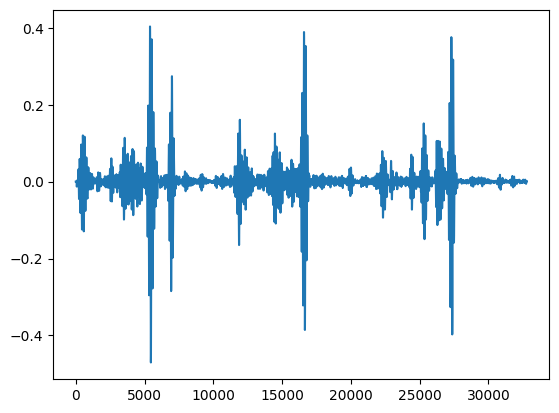

In [ ]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 5]
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [ ]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is: {inferred_class} ({top_score})')

reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')

[YAMNet] The main sound is: Heart sounds, heartbeat (0.9599353075027466)
[Your model] The main sound is: MVP (0.9971734285354614)


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Get true labels and predicted labels from test dataset
y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    logits = my_model(x_batch, training=False)
    predictions = tf.argmax(logits, axis=1)

    y_true.extend(y_batch.numpy())
    y_pred.extend(predictions.numpy())

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Print results
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

# Optional: Detailed report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=my_classes, zero_division=0))


Accuracy : 0.8462
Precision: 0.8507
Recall   : 0.8462
F1-score : 0.8426

Classification Report:
              precision    recall  f1-score   support

          AS       0.85      0.92      0.88       204
          MR       0.82      0.87      0.84       173
          MS       0.92      0.65      0.76       184
         MVP       0.83      0.82      0.82       190
           N       0.84      0.98      0.90       179

    accuracy                           0.85       930
   macro avg       0.85      0.85      0.84       930
weighted avg       0.85      0.85      0.84       930

